<a href="https://colab.research.google.com/github/NeelayS/ppe-detection/blob/main/processing_jsl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/projects/frinks/data/ppe

/content/drive/MyDrive/projects/frinks/data/ppe


# Imports

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, io
from os.path import join
import matplotlib.pyplot as plt

# Data

In [ ]:
class JSLDataset(Dataset):
    def __init__(self, img_dir, annotations_list):
        super().__init__()

        self.img_dir = img_dir

        with open(annotations_list, "r") as f:
            self.annotations = sorted(f.readlines())
        f.close()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):

        annotation = str(self.annotations[idx])[:-1].split("\t")

        img_name = annotation[0]
        img = io.read_image(join(self.img_dir, img_name))

        cropped_detections = []
        labels = []

        for det_annotation in annotation[1:]:

            det_annotation = det_annotation.split(",")[1:]
            det_annotation = [int(e) for e in det_annotation]

            label = det_annotation[-3:]
            labels.append(label)

            x1, y1, x2, y2 = det_annotation[:-3]
            cropped_detection = img[:, y1:y2, x1:x2].float()
            cropped_detections.append(cropped_detection)

        return cropped_detections, labels

In [ ]:
dataset = JSLDataset("images", "annotations_50.txt")

In [ ]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
for data, label in dataloader:
    pass

In [ ]:
sample = next(iter(dataloader))
type(sample), len(sample)

(list, 2)

In [ ]:
sample[1]

[[tensor([1]), tensor([1]), tensor([-1])],
 [tensor([0]), tensor([1]), tensor([1])],
 [tensor([0]), tensor([1]), tensor([1])],
 [tensor([1]), tensor([1]), tensor([1])],
 [tensor([1]), tensor([1]), tensor([1])],
 [tensor([0]), tensor([0]), tensor([-1])],
 [tensor([1]), tensor([0]), tensor([1])],
 [tensor([1]), tensor([1]), tensor([-1])],
 [tensor([1]), tensor([1]), tensor([-1])],
 [tensor([0]), tensor([0]), tensor([1])],
 [tensor([1]), tensor([1]), tensor([-1])]]

In [ ]:
sample[0][0].shape

torch.Size([1, 3, 894, 438])

Label: [tensor([1]), tensor([1]), tensor([-1])]


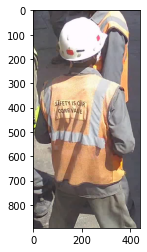

In [ ]:
crop = sample[0][0].squeeze(0).permute(1, 2, 0).long().numpy()
crop_label = sample[1][0]
plt.imshow(crop)
print(f"Label: {crop_label}")

# Model Definition

In [ ]:
!pip install pytorchyolo

     |████████████████████████████████| 42 kB 908 kB/s 
     |████████████████████████████████| 948 kB 9.2 MB/s 
     |████████████████████████████████| 11.2 MB 28.3 MB/s 
     |████████████████████████████████| 3.1 MB 26.7 MB/s 
     |████████████████████████████████| 930 kB 38.4 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have

In [ ]:
import cv2
from pytorchyolo import detect, models as yolo_models
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import io, models


class ClassificationHead(nn.Module):
    def __init__(self, features_dim, layers_config=[1024, 512]):
        super().__init__()

        self.features_dim = features_dim

        layers_config = [features_dim] + list(layers_config)

        self.head = nn.ModuleList()
        for i in range(0, len(layers_config) - 1):
            self.head.append(
                nn.Sequential(
                    nn.Linear(layers_config[i], layers_config[i + 1]),
                    nn.ReLU(),
                ),
            )
        self.head.append(nn.Linear(layers_config[-1], 2))
        self.head = nn.Sequential(*self.head)

    def forward(self, x):

        x = torch.flatten(x, 1)

        return self.head(x)


class YoloV3DetectionModel:
    def __init__(self, config_path, weights_path, threshold=0.5):

        self.threshold = threshold

        self.model = yolo_models.load_model(config_path, weights_path)

    def _filter_detections(self, detections):

        filtered_detections = []

        for detection in detections:

            if (
                detection[-2] > self.threshold and int(detection[-1]) == 0
            ):  # 0 = person class
                filtered_detections.append(list(map(lambda x: int(x), detection[:-2])))

        return filtered_detections

    def __call__(self, img_path):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        detections = detect.detect_image(self.model, img)
        detections = self._filter_detections(detections)

        print(f"Detected {len(detections)} persons")

        img = io.read_image(img_path)

        cropped_detections = []
        for detection in detections:
            cropped_detections.append(
                img[:, detection[1] : detection[3], detection[0] : detection[2]]
                .unsqueeze(0)
                .float()
            )

        return cropped_detections


class ClassificationModel(nn.Module):
    def __init__(
        self, reshape_size, features_dim, layers_config, n_heads, backbone=None
    ):
        super().__init__()

        self.reshape_size = reshape_size

        if backbone is None:
            self.backbone = models.vgg19(pretrained=False).features
        else:
            self.backbone = backbone

        self.heads = nn.ModuleList()
        for _ in range(n_heads):
            self.heads.append(
                ClassificationHead(
                    features_dim=features_dim, layers_config=layers_config
                )
            )

    def forward(self, detections):

        outs = []

        for detection in detections:

            detection = F.interpolate(
                detection, self.reshape_size, mode="bilinear", align_corners=True
            )
            features = self.backbone(detection)

            instance_outs = []

            for head in self.heads:
                out = head(features)
                instance_outs.append(out)

            outs.append(instance_outs)

        return outs


class CompleteModel(nn.Module):
    def __init__(
        self,
        detection_threshold,
        detection_config,
        detection_weights,
        detection_reshape_size,
        classification_features_dim,
        classification_layers_config,
        classification_n_heads,
        classification_model_weights=None,
    ):
        super().__init__()

        self.detection_model = YoloV3DetectionModel(
            config_path=detection_config,
            weights_path=detection_weights,
            threshold=detection_threshold,
        )
        self.classification_model = ClassificationModel(
            reshape_size=detection_reshape_size,
            features_dim=classification_features_dim,
            layers_config=classification_layers_config,
            n_heads=classification_n_heads,
        )

        if classification_model_weights is not None:
            self.classification_model.load_state_dict(classification_model_weights)

    def forward(self, img_path):

        detections = self.detection_model(img_path)
        img_outs = self.classification_model(detections)

        return img_outs


# Map outs for a detection uniquely to the detection
# Pre-process images
# Detection model
# Load pre-trained weights

In [ ]:
model = ClassificationModel((96, 32), 1536, (512, 128), 3)

In [ ]:
out = model(sample[0])
type(out)

list

In [ ]:
out[:2]

[[tensor([[-0.1973, -0.1845]], grad_fn=<AddmmBackward0>),
  tensor([[ 1.1995, -0.5268]], grad_fn=<AddmmBackward0>),
  tensor([[ 0.2240, -0.3425]], grad_fn=<AddmmBackward0>)],
 [tensor([[-0.1803, -0.3481]], grad_fn=<AddmmBackward0>),
  tensor([[ 1.2434, -0.6004]], grad_fn=<AddmmBackward0>),
  tensor([[ 0.5280, -0.6110]], grad_fn=<AddmmBackward0>)]]

In [ ]:
sample[1][:2]

[[tensor([1]), tensor([1]), tensor([-1])],
 [tensor([0]), tensor([1]), tensor([1])]]

In [ ]:
a = []
for o in out[:2]:
    a += o
a

[tensor([[-0.1973, -0.1845]], grad_fn=<AddmmBackward0>),
 tensor([[ 1.1995, -0.5268]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.2240, -0.3425]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1803, -0.3481]], grad_fn=<AddmmBackward0>),
 tensor([[ 1.2434, -0.6004]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.5280, -0.6110]], grad_fn=<AddmmBackward0>)]

In [ ]:
torch.cat(a)

tensor([[-0.1973, -0.1845],
        [ 1.1995, -0.5268],
        [ 0.2240, -0.3425],
        [-0.1803, -0.3481],
        [ 1.2434, -0.6004],
        [ 0.5280, -0.6110]], grad_fn=<CatBackward0>)

In [ ]:
label = torch.LongTensor(sample[1])
label

tensor([[ 1,  1, -1],
        [ 0,  1,  1],
        [ 0,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 0,  0, -1],
        [ 1,  0,  1],
        [ 1,  1, -1],
        [ 1,  1, -1],
        [ 0,  0,  1],
        [ 1,  1, -1]])

In [ ]:
sample[1]

[[tensor([1]), tensor([1]), tensor([-1])],
 [tensor([0]), tensor([1]), tensor([1])],
 [tensor([0]), tensor([1]), tensor([1])],
 [tensor([1]), tensor([1]), tensor([1])],
 [tensor([1]), tensor([1]), tensor([1])],
 [tensor([0]), tensor([0]), tensor([-1])],
 [tensor([1]), tensor([0]), tensor([1])],
 [tensor([1]), tensor([1]), tensor([-1])],
 [tensor([1]), tensor([1]), tensor([-1])],
 [tensor([0]), tensor([0]), tensor([1])],
 [tensor([1]), tensor([1]), tensor([-1])]]

In [ ]:
torch.LongTensor(sample[1])

tensor([[ 1,  1, -1],
        [ 0,  1,  1],
        [ 0,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 0,  0, -1],
        [ 1,  0,  1],
        [ 1,  1, -1],
        [ 1,  1, -1],
        [ 0,  0,  1],
        [ 1,  1, -1]])

# Training

In [ ]:
def loss_fn(preds, labels, device):

    batch_preds = []
    batch_labels = []

    for pred, label in zip(preds, labels):

        if label[-1].item() == -1:
            pred = pred[:-1]
            label = label[:-1]

        batch_preds += pred
        batch_labels += label

    batch_preds = torch.cat(batch_preds).to(device)
    batch_labels = torch.cat(batch_labels).to(device)

    loss = F.cross_entropy(batch_preds, batch_labels)

    return loss

In [ ]:
def train_classifier(model, dataloader, optimizer, epochs, device, save_dir):

    len_dataloader = len(dataloader)

    model = model.to(device)
    model.train()

    epoch_losses = []
    iter_losses = []

    for epoch in range(epochs):

        epoch_loss = 0

        for i, (data, labels) in enumerate(dataloader):

            optimizer.zero_grad()

            data = [d.to(device) for d in data]
            # labels = torch.LongTensor(labels).to(device)
            # data, labels = data.to(device), labels.to(device)

            preds = model(data)

            loss = loss_fn(preds, labels, device)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (i + 1) % 50 == 0:
                print(
                    f"Iteration {(epoch*len_dataloader) + i + 1}: Loss = {loss.item()}"
                )
                iter_losses.append(loss.item())

            if ((epoch * len_dataloader) + i + 1) % 1000 == 0:
                print(f"Saving iteration {(epoch*len_dataloader) + i + 1} checkpoint")
                torch.save(
                    model.state_dict(),
                    join(
                        save_dir,
                        "iter" + str((epoch * len_dataloader) + i + 1) + "_model.pth",
                    ),
                )

        epoch_losses.append(epoch_loss)

    torch.save(model.state_dict(), join(save_dir, "final_model.pth"))

    fig, axs = plt.subplots(1, 2, figsize=(14, 8))
    axs[0].plot(iter_losses)
    axs[0].set_title("Iteration losses")
    axs[1].plot(epoch_losses)
    axs[1].set_title("Epoch losses")
    fig.savefig(join(save_dir, "training_loss_curves.png"))

In [ ]:
train_dataset = JSLDataset("images", "annotations_50.txt")
trainloader = DataLoader(train_dataset, batch_size=1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ClassificationModel((96, 32), 1536, (512, 128), 3)
model = model.to(device)

cuda


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Iteration 50: Loss = 0.4876328408718109
Iteration 100: Loss = 0.48604169487953186
Iteration 150: Loss = 0.5123975872993469
Iteration 200: Loss = 0.6184850335121155
Iteration 250: Loss = 0.6401607394218445
Iteration 300: Loss = 0.6484501361846924
Iteration 350: Loss = 0.6442272067070007
Iteration 400: Loss = 0.5547769069671631
Iteration 450: Loss = 0.43408074975013733
Iteration 500: Loss = 0.48163142800331116
Iteration 550: Loss = 0.44138434529304504
Iteration 600: Loss = 0.512237548828125
Iteration 650: Loss = 0.5152345299720764
Iteration 700: Loss = 0.5318120121955872
Iteration 750: Loss = 0.5684916377067566
Iteration 800: Loss = 0.5353417992591858
Iteration 850: Loss = 0.5860008597373962
Iteration 900: Loss = 0.4760410785675049
Iteration 950: Loss = 0.6554457545280457
Iteration 1000: Loss = 0.4056967496871948
Saving iteration 1000 checkpoint
Iteration 1050: Loss = 0.7038183212280273
Iteration 1100: Loss = 0.4461272954940796
Iteration 1150: Loss = 0.3403204381465912
Iteration 1200: Lo

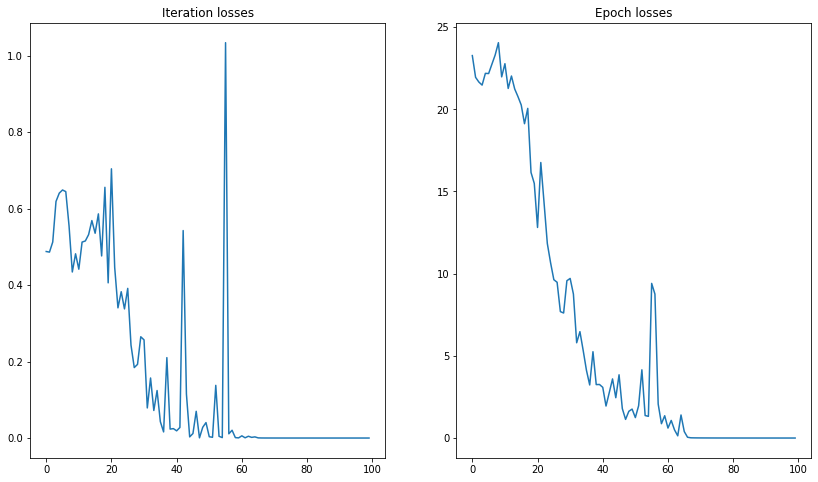

In [ ]:
epochs = 100
train_classifier(
    model,
    trainloader,
    optimizer,
    epochs,
    device,
    "/content/drive/MyDrive/projects/frinks/ppe/model_weights/run2",
)

# Evaluation

In [ ]:
def eval(model, testloader, device, task_id=0):

    n_total = 0
    n_correct = 0

    p = []
    l = []

    for data, labels in testloader:

        data = [d.to(device) for d in data]
        labels = [label[task_id] for label in labels]
        labels = torch.LongTensor(labels).to(device)

        preds = model(data)
        preds = [pred[task_id] for pred in preds]

        preds = torch.cat(preds)
        preds = F.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)

        p += list(preds)
        l += list(labels)

        n_correct += torch.sum(torch.eq(preds, labels))
        n_total += len(labels)

    accuracy = (n_correct / n_total) * 100
    print(f"Accuracy: {accuracy}%")

    p = [i.cpu().item() for i in p]
    l = [i.cpu().item() for i in l]

    return accuracy.item(), p, l

In [ ]:
test_dataset = JSLDataset("images", "annotations_50.txt")
testloader = DataLoader(test_dataset, batch_size=1)
len(test_dataset), len(testloader)

(50, 50)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ClassificationModel((96, 32), 1536, (512, 128), 3)
model.load_state_dict(
    torch.load(
        "/content/drive/MyDrive/projects/frinks/ppe/model_weights/run2/final_model.pth",
        map_location="cpu",
    )
)
model.eval()
model = model.to(device)

cuda


In [ ]:
acc, preds, labels = eval(model, testloader, device, task_id=0)

Accuracy: 100.0%


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
accuracy_score(preds, labels)

1.0

In [ ]:
confusion_matrix(preds, labels)

array([[ 63,   0],
       [  0, 173]])

In [ ]:
sample = next(iter(testloader))

Label: [tensor([0]), tensor([1]), tensor([1])]


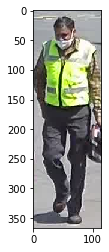

In [ ]:
crop = sample[0][1].squeeze(0).permute(1, 2, 0).long().numpy()
crop_label = sample[1][1]
plt.imshow(crop)
print(f"Label: {crop_label}")

In [ ]:
data = sample[0]
data = [d.to(device) for d in data]
pred = model(data)
torch.argmax(F.softmax(torch.cat(pred[1]), dim=1), dim=1)

tensor([0, 1, 1], device='cuda:0')